<a href="https://colab.research.google.com/github/qcuongning/collab/blob/main/ISIC2017_Xception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Với các hàm cần sử dụng backend Keras mà bị lỗi K not contribute cần đổi về keras==2.2.4


The codebase is heavily inspired by the [respotory](https://github.com/qubvel/efficientnet)



# Get Data

In [ ]:
from zipfile import ZipFile
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
import os
import numpy as np
from matplotlib import pyplot as plt
import json
import cv2
import csv
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications as app
seed = 1234
np.random.seed(seed)
fig=plt.figure()
FJoin = os.path.join

<Figure size 432x288 with 0 Axes>

In [ ]:
file_id = '1m0u6Ic9ZoF-FS-_HRfIHKMdxNXztWLe7'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('ISIC2017')
with ZipFile('ISIC2017', 'r') as tt:
  tt.extractall("")
os.remove("ISIC2017")

In [ ]:
file_id = '1TPLVTEzAgEcFFM2KJ5ijaCzW1oY6a_wX'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('training_mask')
with ZipFile('training_mask', 'r') as tt:
  tt.extractall("")

In [ ]:
file_id = '1Z7BFrqtxm7us2a092St8VKPDOKhud8oh'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('test')
with ZipFile('test', 'r') as tt:
  tt.extractall("")
os.remove("test")

In [ ]:
file_id = '1B0u9c3yeu56rtMmpGSxiY27FZ7iFRxDy'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('test_mask')
with ZipFile('test_mask', 'r') as tt:
  tt.extractall("")

In [ ]:
file_name = 'weights_save'
if not os.path.exists(file_name):
  os.mkdir(file_name)


# Initial Data

lấy các cặp ảnh và mask

ảnh resize về 192x288

mask là binary
đầu ra imgs , masks

In [ ]:
def GetFiles(path):
    file_list, dir_list = [], []
    for dir, subdirs, files in os.walk(path):
        file_list.extend([FJoin(dir, f) for f in files])
        dir_list.extend([FJoin(dir, d) for d in subdirs])
    return file_list, dir_list

def get_mask(image_name,mask_folder):
    mask_path=os.path.join(mask_folder, image_name.replace(".jpg","_segmentation.png"))
    #print(mask_path)
    img_mask = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
    _,img_mask = cv2.threshold(img_mask,127,255,cv2.THRESH_BINARY)
    img_mask = img_mask/255.
    return img_mask


def build_data(path,mask_folder,csv_path,img_shapes):
  w,h = img_shapes
  imgs=[]
  masks=[]
  img_name=[]
  with open(csv_path, 'r') as csvFile:
    reader = csv.reader(csvFile)
    for row in reader:
        img_name.append(row[0])
  for count,file in enumerate(img_name[1:]):
        file+=".jpg"
        fullpath= os.path.join(path,file)
        msk=get_mask(file,mask_folder)
        msk=cv2.resize(msk,(w,h))
        masks.append(msk)
        image=cv2.imread(fullpath)
        image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        #image=image/127.5-1
        image=cv2.resize(image,(w,h))
        imgs.append(image)
        if count%200 == 0:
          plt.figure(count//200)
          plt.subplot(1,2,1).imshow(image,cmap='gray')
          plt.subplot(1,2,2).imshow(msk, cmap = 'gray')
          plt.show()  
  imgs=np.asarray(imgs,dtype=np.float)
  masks=np.asarray(masks,dtype=np.float).reshape(-1,h,w,1)
  print("shape imgs: ",imgs.shape)
  print("shape masks: ",masks.shape)
  return imgs,masks

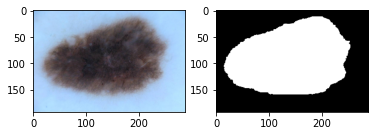

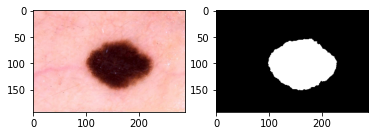

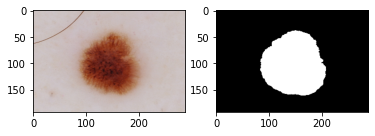

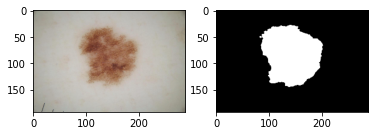

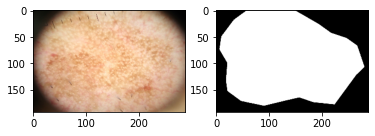

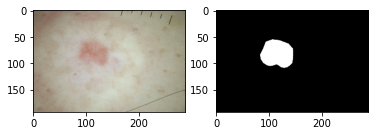

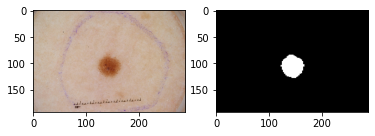

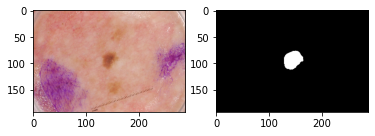

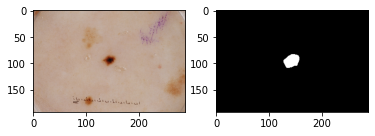

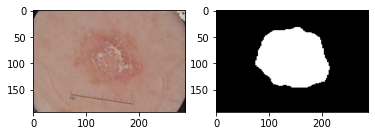

shape imgs:  (2000, 192, 288, 3)
shape masks:  (2000, 192, 288, 1)


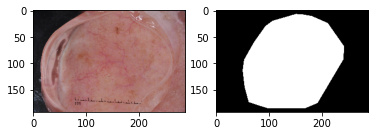

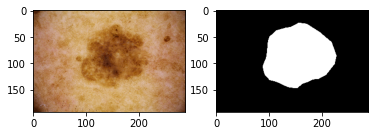

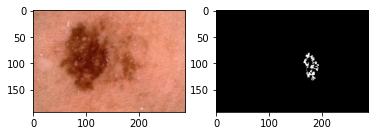

shape imgs:  (600, 192, 288, 3)
shape masks:  (600, 192, 288, 1)


In [ ]:
w = 288
h = 192
folder_train = "/content/ISIC-2017_Training_Data"
mask_train_folder = "/content/ISIC-2017_Training_Part1_GroundTruth"
csv_train = '/content/ISIC-2017_Training_Data/ISIC-2017_Training_Data_metadata.csv'

folder_test="ISIC-2017_Test_v2_Data"
mask_test_folder="ISIC-2017_Test_v2_Part1_GroundTruth"
csv_test = 'ISIC-2017_Test_v2_Data/ISIC-2017_Test_v2_Data_metadata.csv'



imgs,masks = build_data(folder_train,mask_train_folder, csv_train, (w,h))
imgs_test,masks_test = build_data(folder_test,mask_test_folder, csv_test, (w,h))

In [ ]:
masks=masks.reshape(masks.shape[0],masks.shape[1],masks.shape[2],1)
masks_test=masks_test.reshape(masks_test.shape[0],masks_test.shape[1],masks_test.shape[2],1)
print(imgs.shape,masks.shape,imgs_test.shape,masks_test.shape)

(2000, 192, 288, 3) (2000, 192, 288, 1) (600, 192, 288, 3) (600, 192, 288, 1)


In [ ]:
np.random.seed(13)
index = np.random.permutation(imgs_test.shape[0])
img_dev=imgs_test[index[:600]]
mask_dev=masks_test[index[:600]]

In [ ]:
class lr_scheduler(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if epoch == 59 or epoch == 79:
      current_lr = K.eval(self.model.optimizer.lr)
      current_lr = current_lr / 10
      K.set_value(self.model.optimizer.lr, current_lr)
      print(K.eval(self.model.optimizer.lr))

#loss

In [ ]:
def mvn(tensor):
    '''Performs per-channel spatial mean-variance normalization.'''
    epsilon = 1e-6
    mean = K.mean(tensor, axis=(1,2), keepdims=True)
    std = K.std(tensor, axis=(1,2), keepdims=True)
    mvn = (tensor - mean) / (std + epsilon)
    
    return mvn
def dice_coef(y_true, y_pred, smooth=0.0):
    '''Average dice coefficient per batch.'''
    axes = (1,2,3)
    intersection = K.sum(y_true * y_pred, axis=axes) #AhopM
    summation = K.sum(y_true + y_pred, axis=axes)
    
    return K.mean((2.0 * intersection + smooth) / (summation + smooth), axis=0)
def gradientLoss2d(input):
    dH = K.abs(input[:, 1:, :, :] - input[:, :-1, :, :])
    dW = K.abs(input[:, :, 1:, :] - input[:, :, :-1, :])
    dH = dH * dH
    dW = dW * dW
    loss = K.sum(dH) + K.sum(dW)
    return loss
def levelsetLoss(y_true, y_pred, ratio = 0.001):
    #print("go")
    outshape = y_pred.shape
    tarshape = y_true.shape
    multi = y_true*y_pred
    c_numerator = K.sum(multi, [1,2])
    c_denominator = K.sum(y_pred, [1,2])
    #print("outshape,tarshape,multi.shape,c_numerator.shape, c_denominator.shape")
    #print(outshape,tarshape,multi.shape,c_numerator.shape, c_denominator.shape)
    c = c_numerator/c_denominator
    #print("s",c.shape)
    c = K.reshape(c, (-1, 1, 1,outshape[3])) 
    #print("c.shape: ", c.shape)
    plevel = y_true - c
    #print("plevel: ", plevel)
    pLoss = plevel * plevel * y_pred
    lossL = K.mean(pLoss)
    #print("lossL: ", lossL)
    lossA = gradientLoss2d(y_pred) * ratio

    return lossL  + dice_coef_loss(y_true, y_pred)

def dice_coef_loss(y_true, y_pred):
    print(y_true.shape)
    return 1.0 - dice_coef(y_true, y_pred, smooth=10.0)
def bce_dice_loss(y_true, y_pred):
    loss = tf.keras.losses.binary_crossentropy(y_true, y_pred) + dice_coef_loss(y_true, y_pred)
    return loss
def confusion(y_true, y_pred):
    smooth=1
    y_pred_pos = K.clip(y_pred, 0, 1)
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.clip(y_true, 0, 1)
    y_neg = 1 - y_pos
    tp = K.sum(y_pos * y_pred_pos)
    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg) 
    prec = (tp + smooth)/(tp+fp+smooth)
    recall = (tp+smooth)/(tp+fn+smooth)
    return prec, recall
def tp(y_true, y_pred):
    smooth = 1
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pos = K.round(K.clip(y_true, 0, 1))
    tp = (K.sum(y_pos * y_pred_pos) + smooth)/ (K.sum(y_pos) + smooth) 
    return tp 
def tn(y_true, y_pred):
    smooth = 1
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos 
    tn = (K.sum(y_neg * y_pred_neg) + smooth) / (K.sum(y_neg) + smooth )
    return tn 
def tversky(y_true, y_pred):
    smooth=0.0
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)
def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

def focal_tversky(y_true,y_pred):
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

# Data Augument

In [ ]:
#from itertools import izip
generator_x = ImageDataGenerator(
    horizontal_flip = True,
    vertical_flip = True,
    #width_shift_range = 0.2,
    #height_shift_range = 0.2,
    #shear_range = 0.1,
    zoom_range = 0.1,
    rotation_range = 180,
    #fill_mode = 'reflect',
    #brightness_range = (0.9,1.1),
)
generator_y = ImageDataGenerator(
    horizontal_flip = True,
    vertical_flip = True,
    #width_shift_range = 0.2,
    #height_shift_range = 0.2,
    #shear_range = 0.1,
    zoom_range = 0.1,
    #brightness_range = (1.0,1.0),
    rotation_range = 180,
    #fill_mode = 'reflect'
)
seed = 1234
batch = 4

x_gen = generator_x.flow(imgs, batch_size = batch, shuffle = False, seed = seed)
y_gen = generator_y.flow(masks, batch_size = batch, shuffle = False, seed = seed)
train_generator = zip(x_gen, y_gen)

#attention gate

In [ ]:
def attention_up_and_concate(down_layer, layer, data_format='channels_last'):
    data_format='channels_last'

    in_channel = down_layer.get_shape().as_list()[3]

    # up = Conv2DTranspose(out_channel, [2, 2], strides=[2, 2])(down_layer)
    up = UpSampling2D(size=(2, 2), data_format=data_format)(down_layer)

    layer = attention_block_2d(x=layer, g=up, inter_channel=in_channel // 4, data_format=data_format)

    my_concat = Lambda(lambda x: K.concatenate([x[0], x[1]], axis=3))

    concate = my_concat([up, layer])
    return concate
def attention_block_2d(x, g, inter_channel, data_format='channels_last'):
    data_format='channels_last'

    theta_x = Conv2D(inter_channel, [1, 1], strides=[1, 1], data_format=data_format)(x)

    phi_g = Conv2D(inter_channel, [1, 1], strides=[1, 1], data_format=data_format)(g)


    f = Activation('relu')(add([theta_x, phi_g]))


    psi_f = Conv2D(1, [1, 1], strides=[1, 1], data_format=data_format)(f)

    rate = Activation('sigmoid')(psi_f)

    att_x = multiply([x, rate])

    return att_x

In [ ]:
#from tensorflow.keras.applications.imagenet_utils import _obtain_input_shape
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.applications.imagenet_utils import preprocess_input as _preprocess_input
import math
backend=tf.keras.backend
def preprocess_input(x, **kwargs):
    kwargs = {k: v for k, v in kwargs.items() if k in ['backend', 'layers', 'models', 'utils']}
    return _preprocess_input(x, mode='torch', **kwargs)


def get_swish(**kwargs):
    #backend, layers, models, keras_utils = get_submodules_from_kwargs(kwargs)
    def swish(x):
        backend=tf.keras.backend
        """Swish activation function: x * sigmoid(x).
        Reference: [Searching for Activation Functions](https://arxiv.org/abs/1710.05941)
        """

        #if backend.backend() == 'tensorflow':
         #       return backend.tf.nn.swish(x)
        return x * backend.sigmoid(x)
    return  swish


def get_dropout(**kwargs):

    backend, layers, models, keras_utils = get_submodules_from_kwargs(kwargs)

    class FixedDropout(Dropout):
        def _get_noise_shape(self, inputs):
            if self.noise_shape is None:
                return self.noise_shape

            symbolic_shape = backend.shape(inputs)
            noise_shape = [symbolic_shape[axis] if shape is None else shape
                           for axis, shape in enumerate(self.noise_shape)]
            return tuple(noise_shape)

    return FixedDropout


def round_filters(filters, width_coefficient, depth_divisor):
    """Round number of filters based on width multiplier."""

    filters *= width_coefficient
    new_filters = int(filters + depth_divisor / 2) // depth_divisor * depth_divisor
    new_filters = max(depth_divisor, new_filters)
    # Make sure that round down does not go down by more than 10%.
    if new_filters < 0.9 * filters:
        new_filters += depth_divisor
    #print(filters, new_filters)
    return int(new_filters)


def round_repeats(repeats, depth_coefficient):
    """Round number of repeats based on depth multiplier."""

    return int(math.ceil(depth_coefficient * repeats))


def mb_conv_block(inputs, block_args, activation, drop_rate=None, prefix='', mode_down_sample = "depthwise"):
    """Mobile Inverted Residual Bottleneck."""

    has_se = (block_args.se_ratio is not None) and (0 < block_args.se_ratio <= 1)
    bn_axis = 3
    # workaround over non working dropout with None in noise_shape in tf.keras
    Dropout = get_dropout(
        backend=backend,
        layers=layers,
        models=models,
        utils=keras_utils
    )

    # Expansion phase
    filters = block_args.input_filters * block_args.expand_ratio
    if block_args.expand_ratio != 1:
        x = Conv2D(filters, 1,
                          padding='same',
                          use_bias=False,
                          kernel_initializer='random_uniform',
                          name=prefix + 'expand_conv')(inputs)
        x = BatchNormalization(axis=bn_axis, name=prefix + 'expand_bn')(x)
        #x = Lambda(mvn)(x)
        x = Activation(activation, name=prefix + 'expand_activation')(x)
    else:
        x = inputs

    #print("before depth wise: ", x.shape)
    if mode_down_sample == "segnet" and block_args.strides == [2,2] :
          x, indice = MaxPoolingWithIndices(pool_size = (2,2), strides = (2,2), padding = "VALID", name = prefix + "maxpool")(x)
    
    else :
    # Depthwise Convolution
          x = DepthwiseConv2D(block_args.kernel_size,
                                    strides=block_args.strides,
                                    padding='same',
                                    use_bias=False,
                                    depthwise_initializer='random_uniform',
                                    name=prefix + 'dwconv')(x)
          #print("x be:",prefix,x.shape)
          x = BatchNormalization(axis=bn_axis, name=prefix + 'bn')(x)
          #x = Lambda(mvn)(x)
          x = Activation(activation, name=prefix + 'activation')(x)
          indice = 0
    
    # Squeeze and Excitation phase
    if has_se:
        num_reduced_filters = max(1, int(
            block_args.input_filters * block_args.se_ratio
        ))
        se_tensor = GlobalAveragePooling2D(name=prefix + 'se_squeeze')(x)

        target_shape = (1, 1, filters)
        #print(se_tensor.shape,target_shape)
        se_tensor = Reshape(target_shape, name=prefix + 'se_reshape')(se_tensor)
        se_tensor = Conv2D(num_reduced_filters, 1,
                                  activation=activation,
                                  padding='same',
                                  use_bias=True,
                                  kernel_initializer='random_uniform',
                                  name=prefix + 'se_reduce')(se_tensor)
        se_tensor = Conv2D(filters, 1,
                                  activation='sigmoid',
                                  padding='same',
                                  use_bias=True,
                                  kernel_initializer='random_uniform',
                                  name=prefix + 'se_expand')(se_tensor)

        x = multiply([x, se_tensor], name=prefix + 'se_excite')

    # Output phase
    x = Conv2D(block_args.output_filters, 1,
                      padding='same',
                      use_bias=False,
                      kernel_initializer='random_uniform',
                      name=prefix + 'project_conv')(x)
    x = BatchNormalization(axis=bn_axis, name=prefix + 'project_bn')(x)
    #x = Lambda(mvn)(x)
    if block_args.id_skip and all(
            s == 1 for s in block_args.strides
    ) and block_args.input_filters == block_args.output_filters:
        if drop_rate and (drop_rate > 0):
            x = Dropout(drop_rate,
                        noise_shape=(None, 1, 1, 1),
                        name=prefix + 'drop')(x)
        x = add([x, inputs], name=prefix + 'add')

    return x, indice
def get_submodules_from_kwargs(kwargs):
    backend = tf.keras.backend
    layers = tf.keras.layers
    models = tf.keras.models
    utils = tf.keras.utils
    for key in kwargs.keys():
        if key not in ['backend', 'layers', 'models', 'utils']:
            raise TypeError('Invalid keyword argument: %s', key)
    return backend, layers, models, utils


#Xception-unet

In [ ]:
def eff_unet(image_shape,num_class,weights=None):
    inner = Input(shape=image_shape)
    mvn0 = Lambda(mvn)(inner)
    conv1 = Conv2D(64, 3, padding = 'same')(mvn0)
    conv1 = Lambda(mvn)(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, 3,  padding = 'same')(conv1)
    conv1 = Lambda(mvn)(conv1)
    conv1 = Activation('relu')(conv1)
    base =  app.Xception(include_top=False, weights=None, input_tensor= conv1)
    print(base.summary())
    x=base.get_layer("block14_sepconv2_act").output #7x7x1280 chia 32

    #up6 = Conv2D(512, 2,  padding = 'same')(UpSampling2D(size = (2,2))(x)) #14x14x512 chia 16
    #conv6 = Lambda(mvn)(up6)
    #conv6 = Activation('relu')(conv6)
    skip1=base.get_layer("block13_sepconv2_bn").output #chia 16
    print("skip1: ",skip1.shape)
    merge6 = attention_up_and_concate(x,skip1)
    conv6 = Conv2D(1024, 3,  padding = 'same')(merge6)
    conv6 = Lambda(mvn)(conv6)
    conv6 = Activation('relu')(conv6)
    conv6 = Conv2D(1024, 3,  padding = 'same')(conv6)
    conv6 = Lambda(mvn)(conv6)
    conv6 = Activation('relu')(conv6)

    #up7 = Conv2D(256, 2,  padding = 'same')(UpSampling2D(size = (2,2))(conv6)) #28x28 chia 8
    #conv7 = Lambda(mvn)(up7)
    #conv7 = Activation('relu')(conv7)
    skip2 =base.get_layer("block4_sepconv2_bn").output  #chia 8
    print("skip2: ",skip2.shape)
    merge7 = attention_up_and_concate(conv6,skip2)
    conv7 = Conv2D(728, 3,  padding = 'same')(merge7)
    conv7 = Lambda(mvn)(conv7)
    conv7 = Activation('relu')(conv7)
    conv7 = Conv2D(728, 3,  padding = 'same')(conv7)
    conv7 = Lambda(mvn)(conv7)
    conv7 = Activation('relu')(conv7)

    #up8 = Conv2D(128, 2,  padding = 'same')(UpSampling2D(size = (2,2))(conv7)) #56x56 chia 4
    #conv8 = Lambda(mvn)(up8)
    #conv8 = Activation('relu')(conv8)
    skip3 = base.get_layer("block3_sepconv2_bn").output 
    print("skip3: ",skip3.shape)
    skip3 = ZeroPadding2D(((0,1),(0,1)))(skip3)
    merge8 = attention_up_and_concate(conv7,skip3)
    conv8 = Conv2D(256, 3,  padding = 'same')(merge8)
    conv8 = Lambda(mvn)(conv8)
    conv8 = Activation('relu')(conv8)
    conv8 = Conv2D(256, 3,  padding = 'same')(conv8)
    conv8 = Lambda(mvn)(conv8)
    conv8 = Activation('relu')(conv8)

    #up9 = Conv2D(64, 2,  padding = 'same')(UpSampling2D(size = (2,2))(conv8)) #112x112 chia 2
    #conv9 = Lambda(mvn)(up9)
    #conv9 = Activation('relu')(conv9)
    skip4 = base.get_layer("block2_sepconv2_bn").output 
    print("skip4: ",skip4.shape)
    skip4 = ZeroPadding2D(((1,2),(1,2)))(skip4)
    merge9 = attention_up_and_concate(conv8,skip4)
    conv9 = Conv2D(128, 3,  padding = 'same')(merge9)
    conv9 = Lambda(mvn)(conv9)
    conv9 = Activation('relu')(conv9)
    conv9 = Conv2D(128, 3,  padding = 'same')(conv9)
    conv9 = Lambda(mvn)(conv9)
    conv9 = Activation('relu')(conv9)

    #up10 = Conv2D(32, 2,  padding = 'same')(UpSampling2D(size = (2,2))(conv9)) #chia 1
    #conv10 = Lambda(mvn)(up10)
    #conv10 = Activation('relu')(conv10)
    #skip5 = base.get_layer("modifi_conv1_activation").output 
    skip5 =conv1
    print("skip5: ",skip5.shape)
    merge10 = attention_up_and_concate(conv9,skip5)
    conv10 = Conv2D(64, 3,  padding = 'same')(merge10)
    conv10 = Lambda(mvn)(conv10)
    conv10 = Activation('relu')(conv10)
    conv10 = Conv2D(64, 3,  padding = 'same')(conv10)
    conv10 = Lambda(mvn)(conv10)
    conv10 = Activation('relu')(conv10)
    conv10 = Conv2D(2, 3,  padding = 'same')(conv10)
    conv10 = Activation('relu')(conv10)
    output = Conv2D(1, 1, activation = 'sigmoid')(conv10)

    #data = base.get_layer("Input").output
    model = Model(inputs = inner, outputs = output)
    return model



# Fit model

Epoch 60/80
500/500 [==============================] - 288s 576ms/step - loss: 0.3507 - acc: 0.9603 - dice_coef: 0.9069 - jaccard_coef: 0.8409 - val_loss: 0.4036 - val_acc: 0.9290 - val_dice_coef: 0.8515 - val_jaccard_coef: 0.7673

In [ ]:
input_shape = (h, w, 3)
model = eff_unet(input_shape,2)
model.compile(optimizer = SGD(lr = 0.01, momentum = 0.9), loss = focal_tversky, metrics = ['accuracy',dice_coef])
checkpoint = ModelCheckpoint('weights_save/eff_unet.{epoch:02d}_{val_dice_coef:.2f}.hdf5', monitor='val_dice_coef',save_best_only=True, verbose=1, save_weights_only=True, mode='max')
lr_decay = lr_scheduler()
callback_list = [checkpoint]
history = model.fit_generator(train_generator, steps_per_epoch = imgs.shape[0]//4, epochs = 80, validation_data = (img_dev, mask_dev))

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 288, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 192, 288, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 192, 288, 64) 1792        lambda[0][0]                     
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 192, 288, 64) 0           conv2d[0][0]                     
___________________________________________________________________________________________

In [ ]:
model.save_weights("Xception_unet.h5")

In [ ]:
mask_pred = model.predict(img_dev[:100])
mask_pred = mask_pred.astype("float64")

In [ ]:
loss = dice_coef_loss(mask_dev[:100],mask_pred)
loss2 = levelsetLoss(mask_dev[:100],mask_pred)

(100, 192, 288, 1)
(100, 192, 288, 1)


In [ ]:
print(loss)
print(dice_coef(mask_dev[:100],mask_pred))

tf.Tensor(0.1901219827681635, shape=(), dtype=float64)
tf.Tensor(0.8096657455974136, shape=(), dtype=float64)


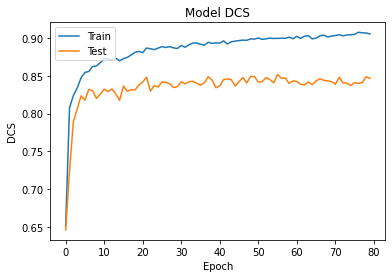

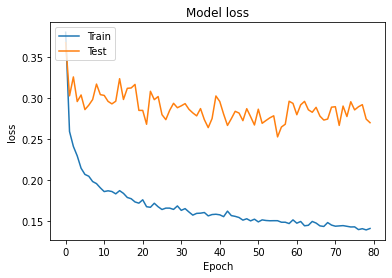

In [ ]:
#plt.figure(1)
#plt.subplot(121,aspect='auto')
y=history.history['val_dice_coef']
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('Model DCS')
plt.ylabel('DCS')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#plt.subplot(122,aspect='auto')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()


#Evaluate

In [ ]:
model.load_weights('weights.03-0.29.hdf5')
model.evaluate(img_dev,mask_dev)

OSError: ignored

#Fit Generator


In [ ]:
nb_layers = [4, 5, 7, 10, 12, 15]
seed=123
input_shape = (w, h, 3)
num_classes = 2
model = Densenet55(input_shape)
model.load_weights('weights.24_0.83.hdf5')
kwargs = dict(
        rotation_range=180,
        zoom_range=0.1,
        width_shift_range=0.0,
        height_shift_range=0.0,
        horizontal_flip=True,
        vertical_flip=True,
    )
image_datagen = ImageDataGenerator(**kwargs)
mask_datagen = ImageDataGenerator(**kwargs)

epochs = 50
mini_batch_size = 4

'''image_generator = image_datagen.flow(img_train, shuffle=False,
                                    batch_size=mini_batch_size, seed=seed)
mask_generator = mask_datagen.flow(mask_train, shuffle=False,
                                    batch_size=mini_batch_size, seed=seed)
train_generator = izip(image_generator, mask_generator)'''
    
max_iter = (imgs.shape[0] // mini_batch_size) * epochs

curr_iter = 0
base_lr = K.eval(model.optimizer.lr)
lrate = lr_poly_decay(model, base_lr, curr_iter, max_iter, power=0.5)
maxdice=0
for e in range(epochs):
        print('\nMain Epoch {:d}'.format(e+1))
        train_result = []
        for iteration in range(len(imgs)//mini_batch_size):
            img, mask = next(train_generator)
            res = model.train_on_batch(img, mask)
            curr_iter += 1
            lrate = lr_poly_decay(model, base_lr, curr_iter,
                                 max_iter, power=0.5)
            train_result.append(res)
        train_result = np.asarray(train_result)
        train_result = np.mean(train_result, axis=0).round(decimals=10)
        print("train_result: ",train_result)
        result = model.evaluate(img_dev, mask_dev, batch_size=32)
        result = np.round(result, decimals=10)
        if result[2]> maxdice:
          maxdice=result[2]
          epoch_max=e+1
          
        print('\nTest set result:', result)
        
        save_file = '_'.join(['ISIC2017_dense_',
                              'epoch', str(e+1)]) + '.h5'
        if not os.path.exists('model_logs'):
            os.makedirs('model_logs')
        save_path = os.path.join('model_logs', save_file)
        print('\nSaving model weights to {:s}'.format(save_path))
        model.save_weights(save_path)
        print(maxdice, epoch_max)

In [ ]:
import os

FJoin = os.path.join

def GetFiles(path):

    file_list, dir_list = [], []
    for dir, subdirs, files in os.walk(path):
        file_list.extend([FJoin(dir, f) for f in files])
        dir_list.extend([FJoin(dir, d) for d in subdirs])
    return file_list, dir_list


files, dirs = GetFiles(os.path.expanduser("weights_save"))
for file in files:
    model.load_weights(file)
    print(model.evaluate(imgs,masks))


In [ ]:
plt.imshow(imgs[5])
plt.show()
plt.imshow(pred[5,:,:,0])
#plt.imshow(masks[5,:,:,0])

#build mat file

In [ ]:
import scipy.io as sio
path1="Matfile"
if not os.path.exists(path1):
            os.makedirs(path1)

for i in range(1,600):
  name1=img_name[i]
  matpath1= os.path.join(path1,name1)
  matpath1+=".mat"
  sio.savemat(matpath1, {'img':images[i-1],'crop_img': imgs[i-1],'ground_truth': masks[i-1], 'predict': mask_predict[i-1]})
  
path2="Matfile/Test"
if not os.path.exists(path2):
            os.makedirs(path2)
for i in range(n,leng):
  name2=img_name[i]
  matpath2= os.path.join(path2,name2)
  matpath2+=".mat"
  sio.savemat(matpath2, {'img':images[i-1],'crop_img': imgs[i-1],'ground_truth': masks[i-1], 'predict': mask_predict[i-1]})

In [ ]:
import shutil
shutil.make_archive('Matfile', 'zip',"Matfile")
